In [20]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import svd
from numpy.typing import ArrayLike, NDArray
from tqdm import tqdm

In [2]:
# Reduzir o valor de elementos de um tensor em tau unidades, evitando troca de sinal
def shrink(X: ArrayLike, tau: float):
    return np.sign(X) * np.maximum(np.abs(X) - tau, 0)

In [41]:
def rpca(
    M: NDArray[np.floating],
    _lamb: float | None = None,
    _mu: float | None = None,
    max_iter: int = 1000,
    tol: float = 1e-7,
):
    m, n = M.shape
    lamb: float = _lamb or 1 / np.sqrt(max(m, n))
    mu: float = _mu or (m * n) / (4 * np.sum(np.abs(M)))
    mat_L = np.zeros_like(M)
    mat_S = np.zeros_like(M)
    mat_Y = np.zeros_like(M)
    n_iter = 0
    for it in tqdm(range(max_iter), desc="Execução do RPCA"):
        mat_U, sigma, mat_Vt = svd(M - mat_S + (1 / mu) * mat_Y, full_matrices=False)
        sigma_shrink = shrink(sigma, 1 / mu)
        mat_L = (mat_U * sigma_shrink) @ mat_Vt
        mat_S = shrink(M - mat_L + (1 / mu) * mat_Y, lamb / mu)
        mat_Z = M - mat_L - mat_S
        mat_Y = mat_Y + mu * mat_Z
        norm = np.linalg.norm(mat_Z, ord="fro") / np.linalg.norm(M, ord="fro")
        print(f"Iteração {it + 1}: erro = {norm:.2e}")
        if norm < tol:
            n_iter = it + 1
            break
    return mat_L, mat_S, n_iter

In [47]:
video_path = "../resources/2025-12-02-18-49-28_C0004.MP4"
cv2_video = cv2.VideoCapture(video_path)
if not cv2_video.isOpened():
    raise IOError("Não foi possível abrir o vídeo.")

orig_fps = cv2_video.get(cv2.CAP_PROP_FPS)
total_frames = int(cv2_video.get(cv2.CAP_PROP_FRAME_COUNT))

frame_interval = int(round(orig_fps / 2))

frames_list = []
frame_idx = 0
while True:
    ret, frame = cv2_video.read()
    if not ret:
        break
    if frame_idx % frame_interval == 0:
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray_frame = gray_frame[::6, ::6]
        frames_list.append(gray_frame / 255.0)
    frame_idx += 1
cv2_video.release()

frames = np.stack(frames_list, axis=2)
print(f"Frames lidos: {frames.shape}")

Frames lidos: (360, 640, 113)


In [60]:
H, W, T = frames.shape
M = frames.reshape(H * W, T)

m, n = M.shape
lambda_rpca_base: float = 1 / np.sqrt(max(m, n))
mu_rpca_base: float = (m * n) / (4 * np.sum(np.abs(M)))

# Os valores de mu não irão mudar, mas os de lambda sim
# Multiplica-se por cada um desses fatores abaixo
factors = [1., 2/3, 3/2, 1/2, 2., 1/4, 4.]
results: dict[float, tuple[np.ndarray, np.ndarray]] = {}
for f in factors:
    lambda_rpca = f * lambda_rpca_base
    L, S, _ = rpca(M, _lamb=lambda_rpca, _mu=mu_rpca_base, max_iter=20)
    results[f] = (L, S)
    # Reconstrução
    total = L + S
    reconstruction_error = np.linalg.norm(M - total, ord="fro") / np.linalg.norm(
        M, ord="fro"
    )
    print(f"Lambda usado: {lambda_rpca:.4e}")
    print(f"Erro de reconstrução relativo: {reconstruction_error:.4e}")

Execução do RPCA:   5%|▌         | 1/20 [00:03<01:06,  3.50s/it]

Iteração 1: erro = 4.10e-03


Execução do RPCA:  10%|█         | 2/20 [00:06<01:02,  3.50s/it]

Iteração 2: erro = 6.80e-04


Execução do RPCA:  15%|█▌        | 3/20 [00:10<01:00,  3.56s/it]

Iteração 3: erro = 4.63e-04


Execução do RPCA:  20%|██        | 4/20 [00:14<00:57,  3.59s/it]

Iteração 4: erro = 4.14e-04


Execução do RPCA:  25%|██▌       | 5/20 [00:18<00:54,  3.67s/it]

Iteração 5: erro = 3.91e-04


Execução do RPCA:  30%|███       | 6/20 [00:21<00:51,  3.67s/it]

Iteração 6: erro = 3.73e-04


Execução do RPCA:  35%|███▌      | 7/20 [00:25<00:47,  3.62s/it]

Iteração 7: erro = 3.61e-04


Execução do RPCA:  40%|████      | 8/20 [00:28<00:43,  3.63s/it]

Iteração 8: erro = 3.51e-04


Execução do RPCA:  45%|████▌     | 9/20 [00:32<00:39,  3.61s/it]

Iteração 9: erro = 3.38e-04


Execução do RPCA:  50%|█████     | 10/20 [00:35<00:35,  3.57s/it]

Iteração 10: erro = 3.18e-04


Execução do RPCA:  55%|█████▌    | 11/20 [00:39<00:32,  3.56s/it]

Iteração 11: erro = 2.97e-04


Execução do RPCA:  60%|██████    | 12/20 [00:43<00:28,  3.55s/it]

Iteração 12: erro = 2.81e-04


Execução do RPCA:  65%|██████▌   | 13/20 [00:46<00:24,  3.55s/it]

Iteração 13: erro = 2.68e-04


Execução do RPCA:  70%|███████   | 14/20 [00:50<00:21,  3.53s/it]

Iteração 14: erro = 2.60e-04


Execução do RPCA:  75%|███████▌  | 15/20 [00:53<00:17,  3.55s/it]

Iteração 15: erro = 2.53e-04


Execução do RPCA:  80%|████████  | 16/20 [00:57<00:14,  3.53s/it]

Iteração 16: erro = 2.49e-04


Execução do RPCA:  85%|████████▌ | 17/20 [01:00<00:10,  3.53s/it]

Iteração 17: erro = 2.40e-04


Execução do RPCA:  90%|█████████ | 18/20 [01:04<00:07,  3.55s/it]

Iteração 18: erro = 2.30e-04


Execução do RPCA:  95%|█████████▌| 19/20 [01:07<00:03,  3.53s/it]

Iteração 19: erro = 2.19e-04


Execução do RPCA: 100%|██████████| 20/20 [01:11<00:00,  3.56s/it]

Iteração 20: erro = 2.06e-04
Lambda usado: 2.0833e-03
Erro de reconstrução relativo: 2.0604e-04



Execução do RPCA:   5%|▌         | 1/20 [00:03<01:07,  3.54s/it]

Iteração 1: erro = 3.25e-03


Execução do RPCA:  10%|█         | 2/20 [00:07<01:05,  3.62s/it]

Iteração 2: erro = 5.81e-04


Execução do RPCA:  15%|█▌        | 3/20 [00:10<01:01,  3.63s/it]

Iteração 3: erro = 4.46e-04


Execução do RPCA:  20%|██        | 4/20 [00:14<00:58,  3.67s/it]

Iteração 4: erro = 4.43e-04


Execução do RPCA:  25%|██▌       | 5/20 [00:18<00:55,  3.69s/it]

Iteração 5: erro = 4.37e-04


Execução do RPCA:  30%|███       | 6/20 [00:21<00:51,  3.69s/it]

Iteração 6: erro = 4.27e-04


Execução do RPCA:  35%|███▌      | 7/20 [00:25<00:47,  3.64s/it]

Iteração 7: erro = 4.11e-04


Execução do RPCA:  40%|████      | 8/20 [00:29<00:44,  3.71s/it]

Iteração 8: erro = 3.97e-04


Execução do RPCA:  45%|████▌     | 9/20 [00:33<00:41,  3.79s/it]

Iteração 9: erro = 3.79e-04


Execução do RPCA:  50%|█████     | 10/20 [00:37<00:37,  3.75s/it]

Iteração 10: erro = 3.64e-04


Execução do RPCA:  55%|█████▌    | 11/20 [00:40<00:33,  3.72s/it]

Iteração 11: erro = 3.51e-04


Execução do RPCA:  60%|██████    | 12/20 [00:44<00:29,  3.69s/it]

Iteração 12: erro = 3.38e-04


Execução do RPCA:  65%|██████▌   | 13/20 [00:47<00:25,  3.66s/it]

Iteração 13: erro = 3.24e-04


Execução do RPCA:  70%|███████   | 14/20 [00:51<00:21,  3.64s/it]

Iteração 14: erro = 3.05e-04


Execução do RPCA:  75%|███████▌  | 15/20 [00:55<00:18,  3.63s/it]

Iteração 15: erro = 2.91e-04


Execução do RPCA:  80%|████████  | 16/20 [00:58<00:14,  3.61s/it]

Iteração 16: erro = 2.79e-04


Execução do RPCA:  85%|████████▌ | 17/20 [01:02<00:10,  3.60s/it]

Iteração 17: erro = 2.70e-04


Execução do RPCA:  90%|█████████ | 18/20 [01:05<00:07,  3.57s/it]

Iteração 18: erro = 2.49e-04


Execução do RPCA:  95%|█████████▌| 19/20 [01:09<00:03,  3.55s/it]

Iteração 19: erro = 2.25e-04


Execução do RPCA: 100%|██████████| 20/20 [01:12<00:00,  3.64s/it]

Iteração 20: erro = 2.08e-04
Lambda usado: 1.3889e-03
Erro de reconstrução relativo: 2.0829e-04



Execução do RPCA:   5%|▌         | 1/20 [00:03<01:04,  3.39s/it]

Iteração 1: erro = 4.87e-03


Execução do RPCA:  10%|█         | 2/20 [00:06<01:03,  3.52s/it]

Iteração 2: erro = 6.62e-04


Execução do RPCA:  15%|█▌        | 3/20 [00:10<01:00,  3.58s/it]

Iteração 3: erro = 3.78e-04


Execução do RPCA:  20%|██        | 4/20 [00:14<00:58,  3.64s/it]

Iteração 4: erro = 3.03e-04


Execução do RPCA:  25%|██▌       | 5/20 [00:18<00:55,  3.69s/it]

Iteração 5: erro = 2.66e-04


Execução do RPCA:  30%|███       | 6/20 [00:21<00:51,  3.69s/it]

Iteração 6: erro = 2.38e-04


Execução do RPCA:  35%|███▌      | 7/20 [00:25<00:47,  3.68s/it]

Iteração 7: erro = 2.16e-04


Execução do RPCA:  40%|████      | 8/20 [00:29<00:44,  3.72s/it]

Iteração 8: erro = 1.98e-04


Execução do RPCA:  45%|████▌     | 9/20 [00:33<00:40,  3.72s/it]

Iteração 9: erro = 1.83e-04


Execução do RPCA:  50%|█████     | 10/20 [00:36<00:37,  3.73s/it]

Iteração 10: erro = 1.69e-04


Execução do RPCA:  55%|█████▌    | 11/20 [00:40<00:33,  3.74s/it]

Iteração 11: erro = 1.58e-04


Execução do RPCA:  60%|██████    | 12/20 [00:44<00:29,  3.70s/it]

Iteração 12: erro = 1.47e-04


Execução do RPCA:  65%|██████▌   | 13/20 [00:47<00:25,  3.65s/it]

Iteração 13: erro = 1.37e-04


Execução do RPCA:  70%|███████   | 14/20 [00:51<00:21,  3.65s/it]

Iteração 14: erro = 1.28e-04


Execução do RPCA:  75%|███████▌  | 15/20 [00:55<00:18,  3.68s/it]

Iteração 15: erro = 1.20e-04


Execução do RPCA:  80%|████████  | 16/20 [00:58<00:14,  3.65s/it]

Iteração 16: erro = 1.12e-04


Execução do RPCA:  85%|████████▌ | 17/20 [01:02<00:11,  3.67s/it]

Iteração 17: erro = 1.03e-04


Execução do RPCA:  90%|█████████ | 18/20 [01:06<00:07,  3.72s/it]

Iteração 18: erro = 9.34e-05


Execução do RPCA:  95%|█████████▌| 19/20 [01:09<00:03,  3.69s/it]

Iteração 19: erro = 8.31e-05


Execução do RPCA: 100%|██████████| 20/20 [01:13<00:00,  3.67s/it]

Iteração 20: erro = 7.28e-05
Lambda usado: 3.1250e-03
Erro de reconstrução relativo: 7.2767e-05



Execução do RPCA:   5%|▌         | 1/20 [00:03<01:06,  3.52s/it]

Iteração 1: erro = 2.67e-03


Execução do RPCA:  10%|█         | 2/20 [00:07<01:03,  3.55s/it]

Iteração 2: erro = 4.70e-04


Execução do RPCA:  15%|█▌        | 3/20 [00:10<01:00,  3.57s/it]

Iteração 3: erro = 3.81e-04


Execução do RPCA:  20%|██        | 4/20 [00:14<00:59,  3.70s/it]

Iteração 4: erro = 3.72e-04


Execução do RPCA:  25%|██▌       | 5/20 [00:18<00:55,  3.67s/it]

Iteração 5: erro = 3.93e-04


Execução do RPCA:  30%|███       | 6/20 [00:21<00:51,  3.65s/it]

Iteração 6: erro = 3.88e-04


Execução do RPCA:  35%|███▌      | 7/20 [00:25<00:47,  3.69s/it]

Iteração 7: erro = 3.72e-04


Execução do RPCA:  40%|████      | 8/20 [00:29<00:44,  3.68s/it]

Iteração 8: erro = 3.58e-04


Execução do RPCA:  45%|████▌     | 9/20 [00:33<00:40,  3.71s/it]

Iteração 9: erro = 3.48e-04


Execução do RPCA:  50%|█████     | 10/20 [00:36<00:36,  3.66s/it]

Iteração 10: erro = 3.34e-04


Execução do RPCA:  55%|█████▌    | 11/20 [00:40<00:32,  3.66s/it]

Iteração 11: erro = 3.17e-04


Execução do RPCA:  60%|██████    | 12/20 [00:43<00:29,  3.63s/it]

Iteração 12: erro = 2.92e-04


Execução do RPCA:  65%|██████▌   | 13/20 [00:47<00:25,  3.62s/it]

Iteração 13: erro = 2.81e-04


Execução do RPCA:  70%|███████   | 14/20 [00:50<00:21,  3.59s/it]

Iteração 14: erro = 2.61e-04


Execução do RPCA:  75%|███████▌  | 15/20 [00:54<00:17,  3.59s/it]

Iteração 15: erro = 2.47e-04


Execução do RPCA:  80%|████████  | 16/20 [00:57<00:14,  3.56s/it]

Iteração 16: erro = 2.35e-04


Execução do RPCA:  85%|████████▌ | 17/20 [01:01<00:10,  3.57s/it]

Iteração 17: erro = 2.21e-04


Execução do RPCA:  90%|█████████ | 18/20 [01:05<00:07,  3.58s/it]

Iteração 18: erro = 1.98e-04


Execução do RPCA:  95%|█████████▌| 19/20 [01:08<00:03,  3.64s/it]

Iteração 19: erro = 1.85e-04


Execução do RPCA: 100%|██████████| 20/20 [01:12<00:00,  3.63s/it]

Iteração 20: erro = 1.78e-04
Lambda usado: 1.0417e-03
Erro de reconstrução relativo: 1.7756e-04



Execução do RPCA:   5%|▌         | 1/20 [00:03<01:07,  3.57s/it]

Iteração 1: erro = 5.30e-03


Execução do RPCA:  10%|█         | 2/20 [00:07<01:05,  3.62s/it]

Iteração 2: erro = 5.91e-04


Execução do RPCA:  15%|█▌        | 3/20 [00:11<01:03,  3.74s/it]

Iteração 3: erro = 3.00e-04


Execução do RPCA:  20%|██        | 4/20 [00:14<00:59,  3.72s/it]

Iteração 4: erro = 2.34e-04


Execução do RPCA:  25%|██▌       | 5/20 [00:18<00:54,  3.66s/it]

Iteração 5: erro = 2.03e-04


Execução do RPCA:  30%|███       | 6/20 [00:22<00:51,  3.69s/it]

Iteração 6: erro = 1.83e-04


Execução do RPCA:  35%|███▌      | 7/20 [00:25<00:47,  3.68s/it]

Iteração 7: erro = 1.68e-04


Execução do RPCA:  40%|████      | 8/20 [00:29<00:43,  3.62s/it]

Iteração 8: erro = 1.55e-04


Execução do RPCA:  45%|████▌     | 9/20 [00:32<00:39,  3.61s/it]

Iteração 9: erro = 1.45e-04


Execução do RPCA:  50%|█████     | 10/20 [00:36<00:36,  3.61s/it]

Iteração 10: erro = 1.36e-04


Execução do RPCA:  55%|█████▌    | 11/20 [00:40<00:32,  3.65s/it]

Iteração 11: erro = 1.27e-04


Execução do RPCA:  60%|██████    | 12/20 [00:43<00:29,  3.67s/it]

Iteração 12: erro = 1.19e-04


Execução do RPCA:  65%|██████▌   | 13/20 [00:47<00:26,  3.72s/it]

Iteração 13: erro = 1.11e-04


Execução do RPCA:  70%|███████   | 14/20 [00:51<00:22,  3.76s/it]

Iteração 14: erro = 1.04e-04


Execução do RPCA:  75%|███████▌  | 15/20 [00:55<00:18,  3.72s/it]

Iteração 15: erro = 9.74e-05


Execução do RPCA:  80%|████████  | 16/20 [00:58<00:14,  3.71s/it]

Iteração 16: erro = 9.07e-05


Execução do RPCA:  85%|████████▌ | 17/20 [01:02<00:11,  3.71s/it]

Iteração 17: erro = 8.37e-05


Execução do RPCA:  90%|█████████ | 18/20 [01:06<00:07,  3.65s/it]

Iteração 18: erro = 7.62e-05


Execução do RPCA:  95%|█████████▌| 19/20 [01:09<00:03,  3.63s/it]

Iteração 19: erro = 6.86e-05


Execução do RPCA: 100%|██████████| 20/20 [01:13<00:00,  3.66s/it]

Iteração 20: erro = 6.11e-05
Lambda usado: 4.1667e-03
Erro de reconstrução relativo: 6.1051e-05



Execução do RPCA:   5%|▌         | 1/20 [00:03<01:07,  3.57s/it]

Iteração 1: erro = 1.53e-03


Execução do RPCA:  10%|█         | 2/20 [00:07<01:04,  3.57s/it]

Iteração 2: erro = 2.24e-04


Execução do RPCA:  15%|█▌        | 3/20 [00:10<01:01,  3.60s/it]

Iteração 3: erro = 1.86e-04


Execução do RPCA:  20%|██        | 4/20 [00:14<00:57,  3.62s/it]

Iteração 4: erro = 2.84e-04


Execução do RPCA:  25%|██▌       | 5/20 [00:18<00:54,  3.62s/it]

Iteração 5: erro = 2.84e-04


Execução do RPCA:  30%|███       | 6/20 [00:21<00:50,  3.64s/it]

Iteração 6: erro = 2.65e-04


Execução do RPCA:  35%|███▌      | 7/20 [00:25<00:47,  3.67s/it]

Iteração 7: erro = 2.60e-04


Execução do RPCA:  40%|████      | 8/20 [00:29<00:44,  3.70s/it]

Iteração 8: erro = 2.49e-04


Execução do RPCA:  45%|████▌     | 9/20 [00:32<00:40,  3.65s/it]

Iteração 9: erro = 2.34e-04


Execução do RPCA:  50%|█████     | 10/20 [00:36<00:36,  3.65s/it]

Iteração 10: erro = 2.16e-04


Execução do RPCA:  55%|█████▌    | 11/20 [00:40<00:32,  3.66s/it]

Iteração 11: erro = 1.97e-04


Execução do RPCA:  60%|██████    | 12/20 [00:43<00:29,  3.64s/it]

Iteração 12: erro = 1.83e-04


Execução do RPCA:  65%|██████▌   | 13/20 [00:47<00:25,  3.65s/it]

Iteração 13: erro = 1.79e-04


Execução do RPCA:  70%|███████   | 14/20 [00:51<00:21,  3.65s/it]

Iteração 14: erro = 1.72e-04


Execução do RPCA:  75%|███████▌  | 15/20 [00:54<00:18,  3.67s/it]

Iteração 15: erro = 1.59e-04


Execução do RPCA:  80%|████████  | 16/20 [00:58<00:14,  3.73s/it]

Iteração 16: erro = 1.41e-04


Execução do RPCA:  85%|████████▌ | 17/20 [01:02<00:11,  3.79s/it]

Iteração 17: erro = 1.28e-04


Execução do RPCA:  90%|█████████ | 18/20 [01:06<00:07,  3.82s/it]

Iteração 18: erro = 1.25e-04


Execução do RPCA:  95%|█████████▌| 19/20 [01:10<00:03,  3.84s/it]

Iteração 19: erro = 1.23e-04


Execução do RPCA: 100%|██████████| 20/20 [01:14<00:00,  3.70s/it]

Iteração 20: erro = 1.22e-04
Lambda usado: 5.2083e-04
Erro de reconstrução relativo: 1.2199e-04



Execução do RPCA:   5%|▌         | 1/20 [00:03<01:07,  3.58s/it]

Iteração 1: erro = 6.01e-03


Execução do RPCA:  10%|█         | 2/20 [00:07<01:06,  3.67s/it]

Iteração 2: erro = 3.80e-04


Execução do RPCA:  15%|█▌        | 3/20 [00:10<01:02,  3.65s/it]

Iteração 3: erro = 1.76e-04


Execução do RPCA:  20%|██        | 4/20 [00:14<00:57,  3.62s/it]

Iteração 4: erro = 1.39e-04


Execução do RPCA:  25%|██▌       | 5/20 [00:18<00:54,  3.65s/it]

Iteração 5: erro = 1.22e-04


Execução do RPCA:  30%|███       | 6/20 [00:21<00:51,  3.66s/it]

Iteração 6: erro = 1.10e-04


Execução do RPCA:  35%|███▌      | 7/20 [00:25<00:47,  3.62s/it]

Iteração 7: erro = 1.01e-04


Execução do RPCA:  40%|████      | 8/20 [00:29<00:43,  3.61s/it]

Iteração 8: erro = 9.28e-05


Execução do RPCA:  45%|████▌     | 9/20 [00:32<00:40,  3.68s/it]

Iteração 9: erro = 8.63e-05


Execução do RPCA:  50%|█████     | 10/20 [00:36<00:36,  3.65s/it]

Iteração 10: erro = 8.08e-05


Execução do RPCA:  55%|█████▌    | 11/20 [00:39<00:32,  3.61s/it]

Iteração 11: erro = 7.56e-05


Execução do RPCA:  60%|██████    | 12/20 [00:43<00:28,  3.57s/it]

Iteração 12: erro = 7.10e-05


Execução do RPCA:  65%|██████▌   | 13/20 [00:47<00:25,  3.64s/it]

Iteração 13: erro = 6.68e-05


Execução do RPCA:  70%|███████   | 14/20 [00:51<00:22,  3.69s/it]

Iteração 14: erro = 6.28e-05


Execução do RPCA:  75%|███████▌  | 15/20 [00:54<00:18,  3.69s/it]

Iteração 15: erro = 5.90e-05


Execução do RPCA:  80%|████████  | 16/20 [00:58<00:14,  3.73s/it]

Iteração 16: erro = 5.51e-05


Execução do RPCA:  85%|████████▌ | 17/20 [01:02<00:11,  3.77s/it]

Iteração 17: erro = 5.16e-05


Execução do RPCA:  90%|█████████ | 18/20 [01:06<00:07,  3.80s/it]

Iteração 18: erro = 4.81e-05


Execução do RPCA:  95%|█████████▌| 19/20 [01:10<00:03,  3.88s/it]

Iteração 19: erro = 4.45e-05


Execução do RPCA: 100%|██████████| 20/20 [01:14<00:00,  3.71s/it]

Iteração 20: erro = 4.13e-05
Lambda usado: 8.3333e-03
Erro de reconstrução relativo: 4.1290e-05


Salvando os resultados porque esse processo demora vários minutos.

In [65]:
results_dict_np = {str(f): (L, S) for f, (L, S) in results.items()}

In [68]:
np.savez("../resources/ls_decomposition_results.npz", **results_dict_np)

In [69]:
def show_frames(idx: int, mat_L: NDArray[np.floating], mat_S: NDArray[np.floating]):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(M[:, idx].reshape(H, W), cmap="gray")
    plt.axis("off")
    plt.subplot(1, 3, 2)
    plt.title("Fundo (L)")
    plt.imshow(mat_L[:, idx].reshape(H, W), cmap="gray")
    plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.title("Movimento (S)")
    plt.imshow(mat_S[:, idx].reshape(H, W), cmap="gray")
    plt.axis("off")
    plt.show()

Abaixo, selecionou-se o frame 4 para visualização dos resultados da decomposição em _low-rank_ e _sparse_, conforme diferentes valores do parâmetro lambda.

Resultados para lambda: 2.0833e-03


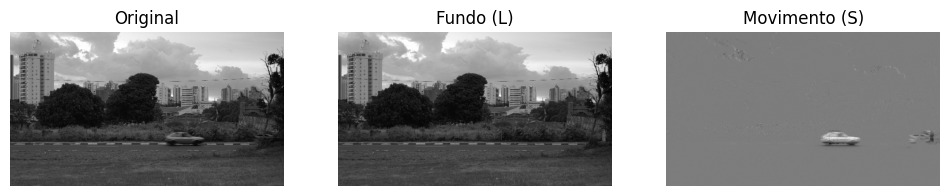

Resultados para lambda: 1.3889e-03


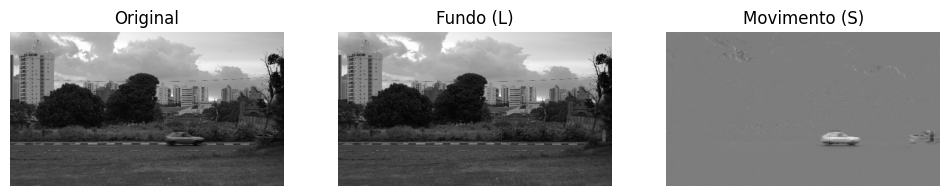

Resultados para lambda: 3.1250e-03


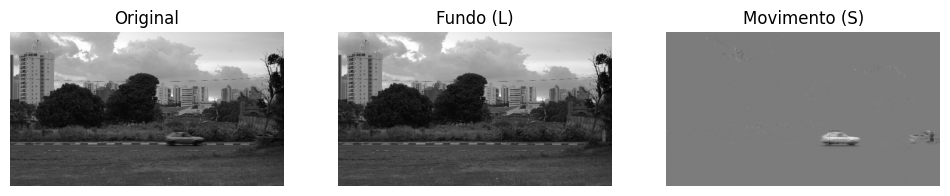

Resultados para lambda: 1.0417e-03


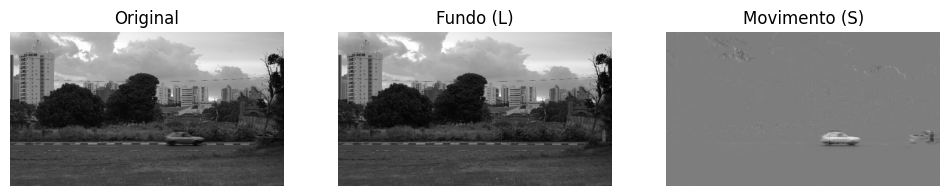

Resultados para lambda: 4.1667e-03


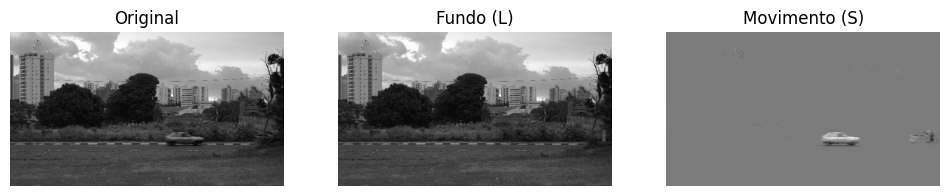

Resultados para lambda: 5.2083e-04


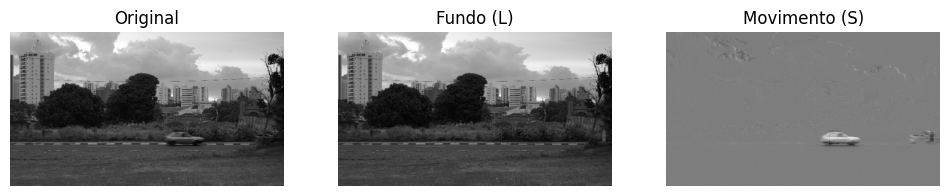

Resultados para lambda: 8.3333e-03


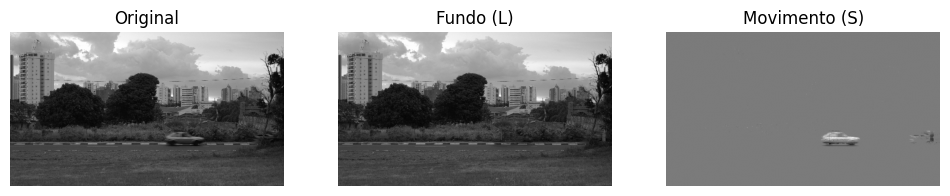

In [70]:
for idx, factor in enumerate(factors):
    L, S = results[factor]
    print(f"Resultados para lambda: {factor * lambda_rpca_base:.4e}")
    show_frames(3, L, S)

É possível perceber uma melhor separação entre o fundo e o movimento conforme o valor de lambda aumenta, principalmente em partes do céu.

Para o sétimo frame:

Resultados para lambda: 2.0833e-03


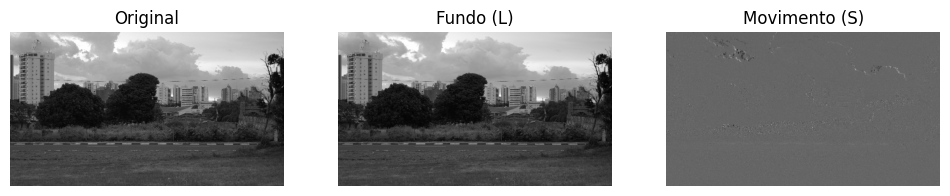

Resultados para lambda: 1.3889e-03


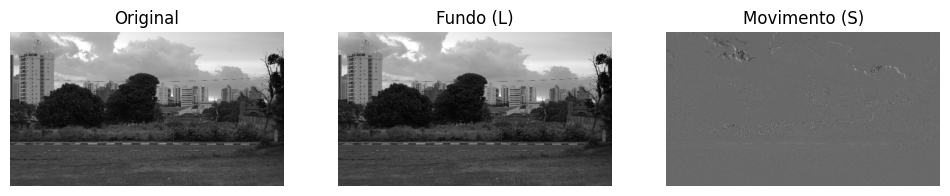

Resultados para lambda: 3.1250e-03


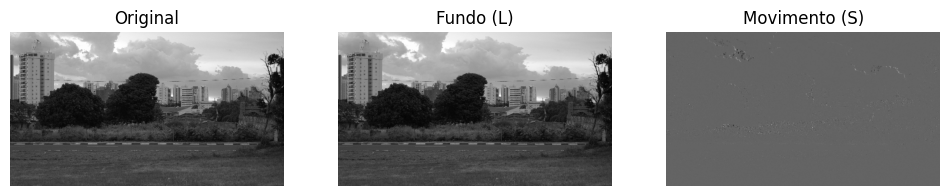

Resultados para lambda: 1.0417e-03


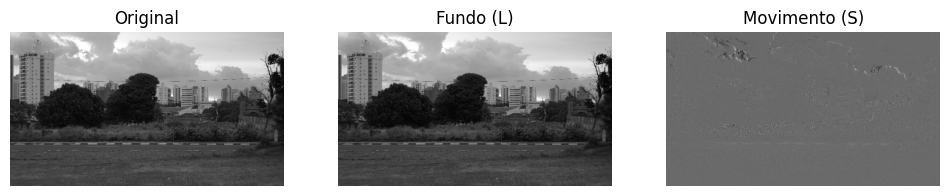

Resultados para lambda: 4.1667e-03


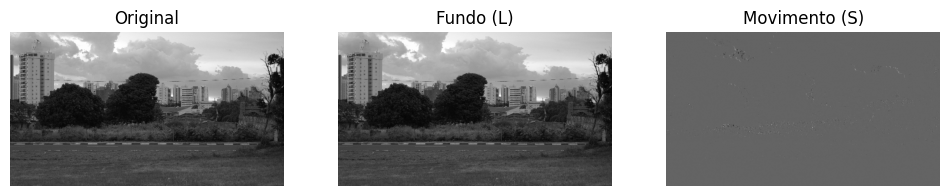

Resultados para lambda: 5.2083e-04


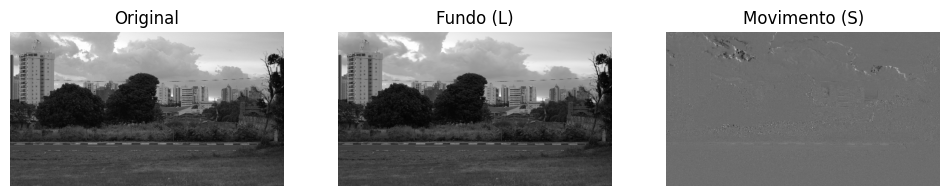

Resultados para lambda: 8.3333e-03


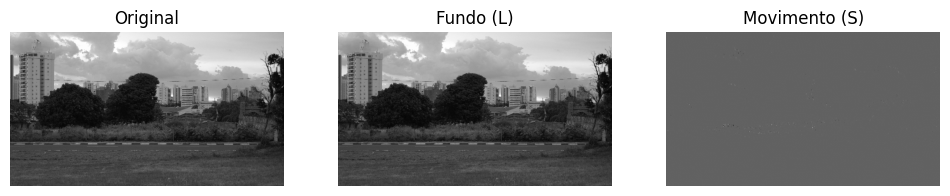

In [71]:
for idx, factor in enumerate(factors):
    L, S = results[factor]
    print(f"Resultados para lambda: {factor * lambda_rpca_base:.4e}")
    show_frames(6, L, S)

Nesse caso o "movimento" detectado está focado principalmente na área em que aparecem as nuvens. 

Por fim, vamos pegar mais um frame em que um carro aparece: o frame 53.

Resultados para lambda: 2.0833e-03


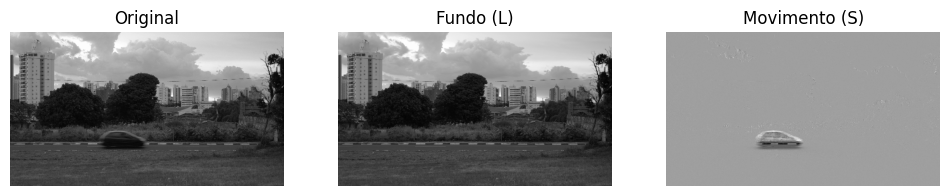

Resultados para lambda: 1.3889e-03


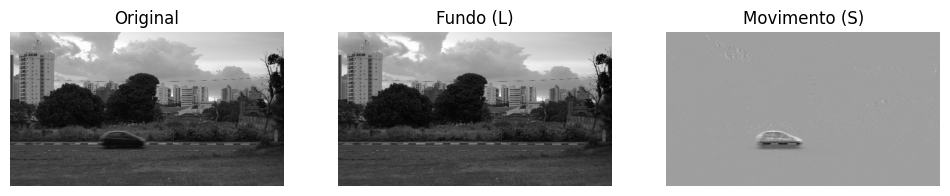

Resultados para lambda: 3.1250e-03


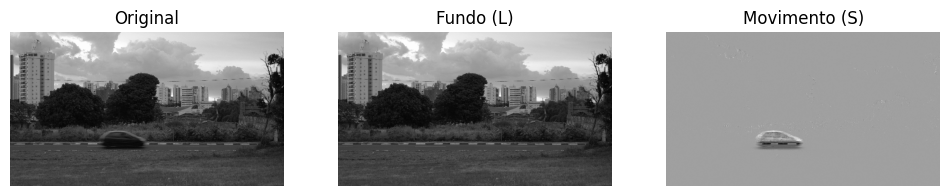

Resultados para lambda: 1.0417e-03


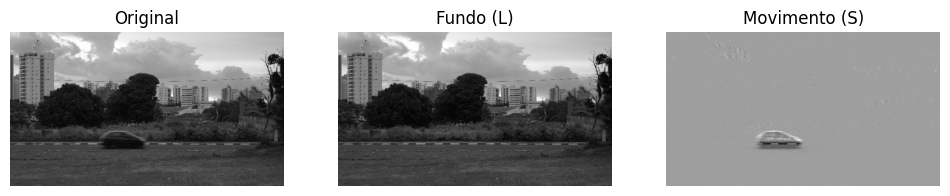

Resultados para lambda: 4.1667e-03


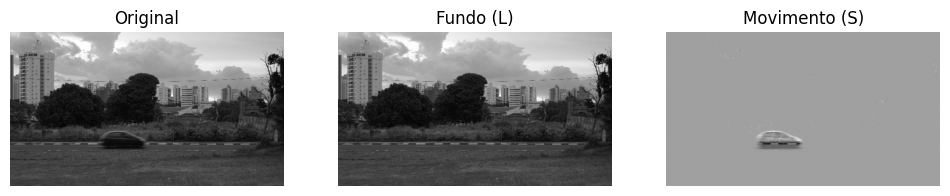

Resultados para lambda: 5.2083e-04


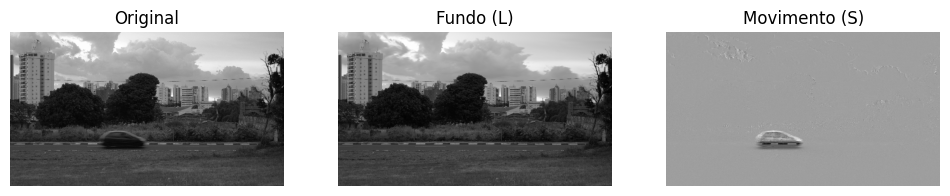

Resultados para lambda: 8.3333e-03


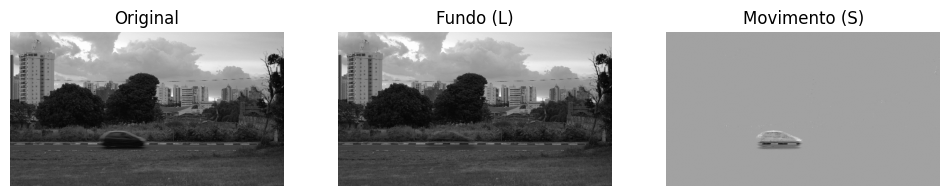

In [86]:
for idx, factor in enumerate(factors):
    L, S = results[factor]
    print(f"Resultados para lambda: {factor * lambda_rpca_base:.4e}")
    show_frames(52, L, S)